In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *


In [3]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_lscale_vv_0001.dat', 'shearlayer_lscale_vv_0002.dat', 'shearlayer_lscale_vv_0003.dat', 'shearlayer_lscale_vv_0004.dat', 'shearlayer_lscale_vv_0005.dat', 'shearlayer_lscale_vv_0006.dat', 'shearlayer_lscale_vv_0007.dat', 'shearlayer_lscale_vv_0008.dat', 'shearlayer_lscale_vv_0009.dat', 'shearlayer_lscale_vv_0010.dat', 'shearlayer_lscale_vv_0011.dat', 'shearlayer_lscale_vv_0012.dat', 'shearlayer_lscale_vv_0013.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
Mean, std: [0.530383138391, 0.145945735633]


array([[0.79973324, 0.57908939, 0.4555337 , 0.46813139, 0.3295636 ,
        0.33655383, 0.29837725, 0.31933917, 0.29428125, 0.30589135,
        0.20253008, 0.22140113, 0.19941641],
       [1.43745681, 1.43745681, 1.54803041, 1.87975121, 1.87975121,
        2.10089841, 2.21147201, 2.32204561, 2.43261921, 2.43261921,
        2.54319281, 2.65376641, 2.76434001],
       [1.21907277, 1.28716008, 1.32140512, 1.34973834, 1.36617753,
        1.38610336, 1.40608748, 1.42391995, 1.42853966, 1.43461943,
        1.44018023, 1.44477028, 1.44334315],
       [0.94299702, 0.64670744, 0.53365922, 0.6519564 , 0.4534532 ,
        0.51011015, 0.46928299, 0.52075969, 0.50112309, 0.51868612,
        0.35764486, 0.4066715 , 0.38192911]])

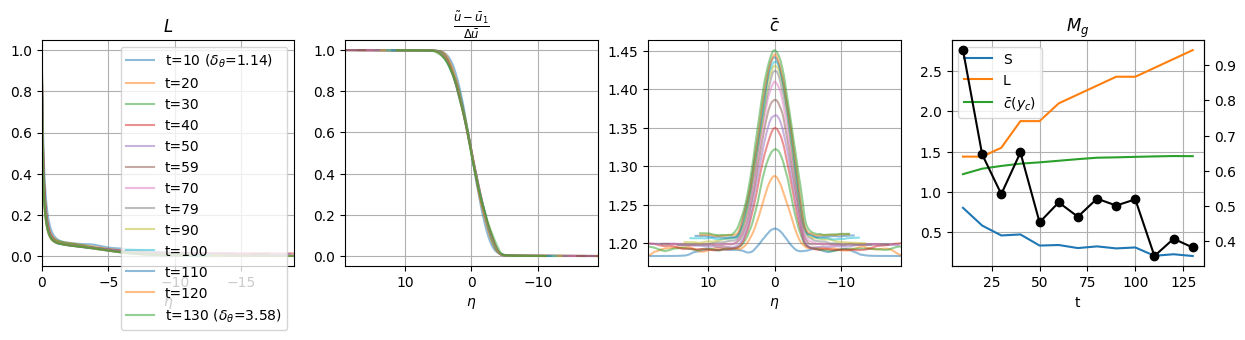

In [5]:

def plot_Mg(directory,inp,flist_plot,istat=0,savename=''):
    fig,ax = plt.subplots(1,4,figsize=(15,3), dpi=100)

    if len(flist_plot)>=15: flist_plot = flist_plot[::2]

    mat = np.zeros([4,len(flist_plot)])
    tlist = np.zeros(len(flist_plot))
    alpha = 0.5

    for count,fname in zip(range(len(flist_plot)),flist_plot):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)
        
        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        if (count==0 or count==len(flist_plot)-1):
            lbl = r't=%d ($\delta_{\theta}$=%0.2f)'%(time,dtheta)
        else: 
            lbl = 't=%d'%time

        # Get centerline
        ic,yc = get_centerline(directory,y,tID)

        # Get integral lengthscale
        dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
        dat = np.fft.fftshift(dat)
        L_int = get_lscale(y,dat)
        ax[0].plot(eta, dat, alpha=alpha,label=lbl)

        # Get shear S
        utilde = np.fromfile( directory + 'shearlayer_utilde_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        offset = 2
        i1 = ic-offset
        i2 = ic+offset
        dy = y[i1]-y[i2]
        S = (utilde[i1]-utilde[i2])/dy  
        L99,i1,i2 = get_L99(y,-utilde)
        ax[1].plot(eta, (utilde-utilde[0])/inp.du, alpha=alpha)

        # Get cbar
        cbar = np.fromfile( directory + 'shearlayer_cbar_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        ax[2].plot(eta, cbar, alpha=alpha)        

        # Record for later
        Mg = S*L_int/cbar[ic]
        tlist[count] = time
        mat[0,count] = S
        mat[1,count] = L_int
        mat[2,count] = cbar[ic]
        mat[3,count] = Mg


    # Plot vs. time
    titles = ['S','L',r'$\bar{c}(y_c)$']
    for count, title in enumerate(titles[:]):
        ax[3].plot(tlist,mat[count,:],label=title)
    ax2 = ax[3].twinx()
    ax2.plot(tlist,mat[-1,:],'k-o',label=r'$M_g$')
    ax[3].set_title(r'$M_g$')

    # Clean up plot
    xmax = L99/2.
    ax[0].set_xlim([0.,xmax])
    ax[1].set_xlim([-xmax,xmax])
    ax[2].set_xlim([-xmax,xmax])
    ax[0].set_title(r'$L$')
    ax[1].set_title(r'$\frac{\tilde{u}-\bar{u}_1}{\Delta \bar{u}}$')
    ax[2].set_title(r'$\bar{c}$')
    ax[0].legend()
    for a in ax:
        a.grid(True)
        a.set_xlabel(r'$\eta$')
    ax[3].legend(titles)
    ax[3].set_xlabel('t')

    # set the overall title and save
    # fig.suptitle('Time: {}'.format(np.around(reader.time,-1)),size=fs,y=0.95)
    if savename:
        fig.savefig(savename, dpi=200,bbox_inches='tight')
        plt.close(fig)
        print "Saved plot to ",savename
    else: 
        print(directory)
        print("Mean, std: [{}, {}]".format(np.mean(mat[3,istat:]),np.std(mat[3,istat:])))
        fig.show()
    return mat

plot_Mg(directory,inp,flist[:],istat=0,savename='')

In [23]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*lscale_vv*")
    flist.sort()

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    # Plot Rij
    plot_Mg(directory,inp,flist[:],istat=0,savename=directory+'/img/Mg.png')
print('Done')

Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512//img/Mg.png
Done


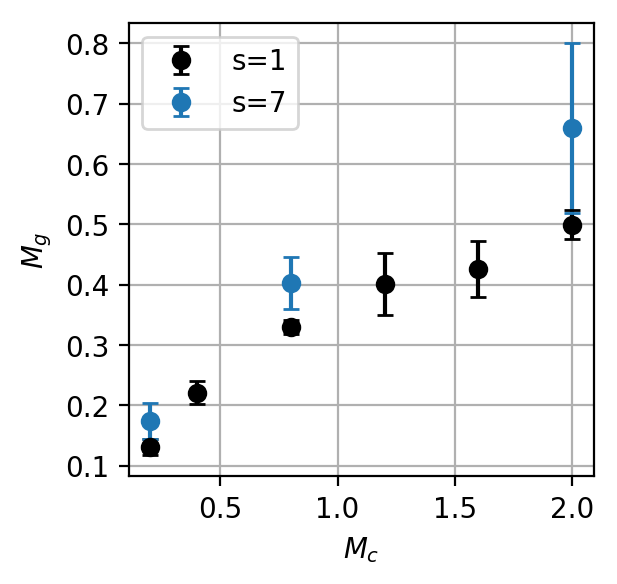

In [9]:
# PadeOps
fs = 14
fig = plt.figure(figsize=(3,3),dpi=200)

Mg = {
    0.2: [0.130436687026, 0.0130058738824],
    0.4: [0.220549356693, 0.0192357782093],
    0.8: [0.330251214502, 0.0113992419973],
    1.2: [0.401280304809, 0.0508855572847],
    1.6: [0.425876374613, 0.0456586507061],
    2.0: [0.499586892666, 0.0243031664111]}

Mg_rr7 = {
    0.2: [0.165302716754, 0.0144092264261],
    0.8: [0.416236223849, 0.0103215363705],
    2.0: [0.713714293268, 0.0398649019376]}

Mg_rr_7 = {
    0.2: [0.183555990595, 0.0146477831479],
    0.8: [0.389142917011, 0.0280491555446],
    2.0: [0.605482964969, 0.0766708091348]}

Mg_Freund = {
0.0996234234593239: 0.29936838749526773,
0.1992468469186476: 0.5987118691346711,
0.4087349817689136: 1.2046713423260078,
0.5934965829165755: 1.4890837633744445,
0.8023072784873182: 1.8465077008906334,
0.9896790133296143: 1.8385129211580227,
1.2826515770387936: 1.8228222319631793,
1.5423897666819428: 2.114270557293431,
1.8011317220904983: 2.0402254478072885
}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = (e1**2+e2**2)**0.5 + np.std([v1,v2])
        new[key] = [(v1+v2)/2., err]
    return new

rr = merge_dicts(Mg_rr7,Mg_rr_7)

plt.errorbar(Mg.keys(),[x[0] for x in Mg.values()], yerr=[x[1] for x in Mg.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar([k+0.02 for k in Mg_rr7.keys()],[x[0] for x in Mg_rr7.values()], yerr=[x[1] for x in Mg_rr7.values()],fmt='o',label='s=7',capsize=3)
# plt.errorbar([k-0.02 for k in Mg_rr_7.keys()],[x[0] for x in Mg_rr_7.values()], yerr=[x[1] for x in Mg_rr_7.values()],fmt='o',label='s=1/7',capsize=3)
# plt.plot(Mg_Freund.keys(),Mg_Freund.values(),'o',label='Freund 2000')
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)

plt.legend()
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$M_g$')
# plt.ylim([0,0.4])
plt.savefig('/home/kmatsuno/ShearLayer_img/Mg.png',dpi=200, bbox_inches='tight')

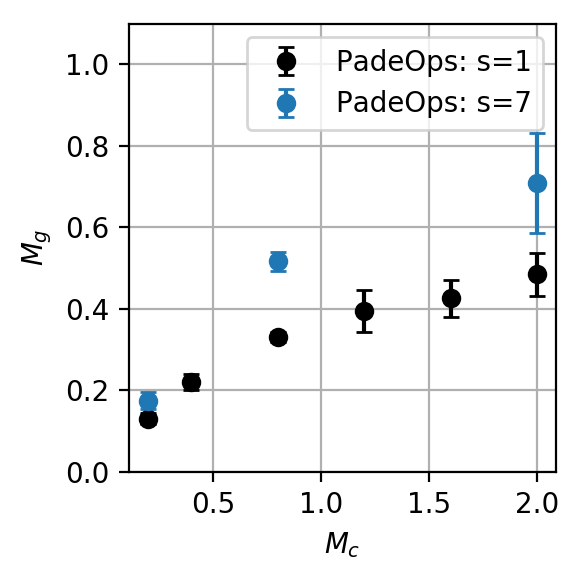

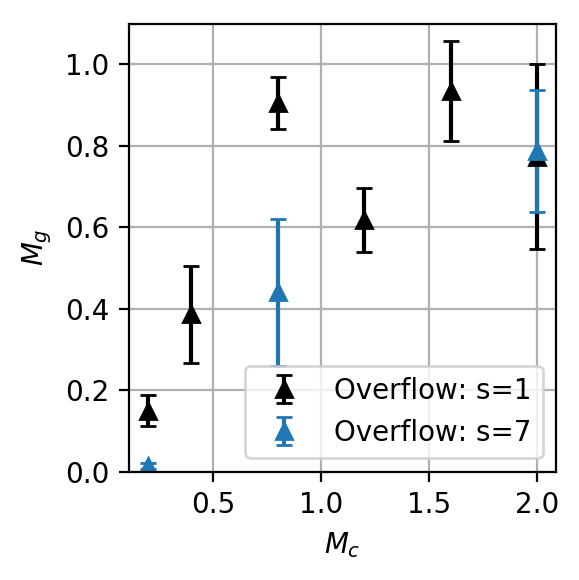

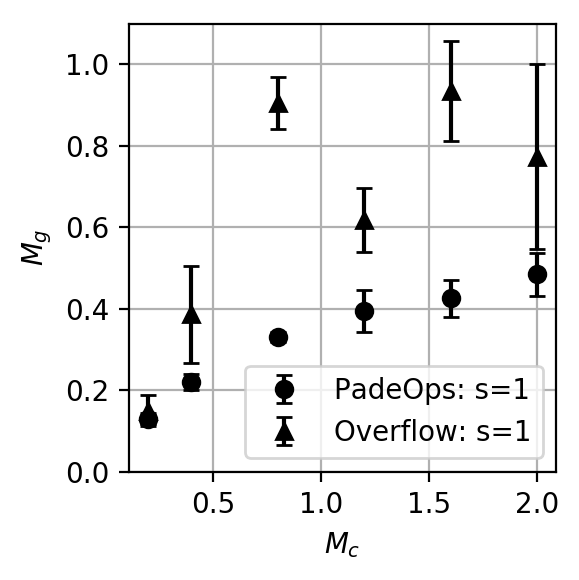

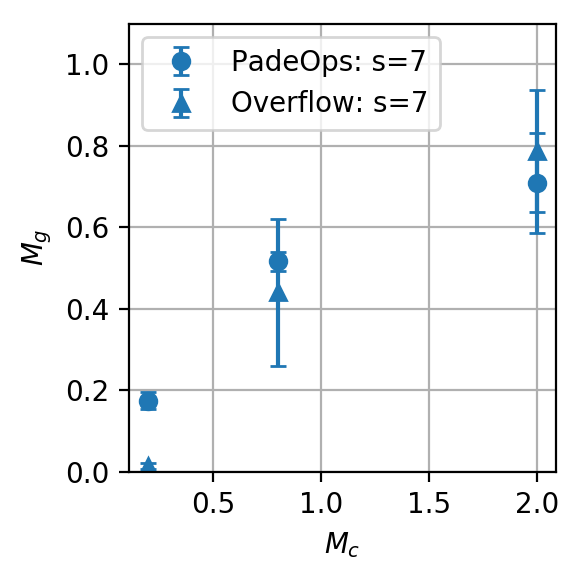

In [62]:
#OVERFLOW: 

Mg_ovf = {
    0.2: [0.149, 0.038],
    0.4: [0.386, 0.119],
    0.8: [0.905, 0.064],
    1.2: [0.617, 0.078],
    1.6: [0.935, 0.123],
    2.0: [0.773, 0.227] }
Mg_rr_7_ovf = {
    0.2: [0.011, 0.003],
    0.8: [0.531, 0.155],
    2.0: [0.959, 0.129]}
Mg_rr7_ovf = {
    0.2: [0.017, 0.007],
    0.8: [0.349, 0.093],
    2.0: [0.613, 0.076]}

DPI=200 
def make_nice():
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$M_c$')
    plt.ylabel(r'$M_g$')
    plt.ylim([0,1.1])
    plt.tight_layout()
    
Lvv = Mg
Lvv_rr_7 = Mg_rr_7
Lvv_rr7 = Mg_rr7
Lvv_ovf = Mg_ovf
Lvv_rr_7_ovf = Mg_rr_7_ovf
Lvv_rr7_ovf = Mg_rr7_ovf

rr_ovf = merge_dicts(Lvv_rr7_ovf,Lvv_rr_7_ovf)

DPI=200 
prefix = '/home/kmatsuno/Ovf_compare/Mg_'

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7.keys(),[x[0] for x in Lvv_rr_7.values()],yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='PadeOps: s=1/7',color='C0',capsize=3)
# plt.errorbar(Lvv_rr7.keys(),[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='PadeOps: s=7',color='C1',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'padeops.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7_ovf.keys(),[x[0] for x in Lvv_rr_7_ovf.values()], yerr=[x[1] for x in Lvv_rr_7_ovf.values()],fmt='^',color='C0',label='Overflow: s=1/7',capsize=3)
# plt.errorbar(Lvv_rr7_ovf.keys(),[x[0] for x in Lvv_rr7_ovf.values()], yerr=[x[1] for x in Lvv_rr7_ovf.values()],fmt='^',color='C1',label='Overflow: s=7',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'ovf.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
make_nice()
plt.savefig(prefix+'rr1.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()],yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',color='C0',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',color='C0',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'rr7.png',dpi=DPI, bbox_inches='tight')
